In [1]:
import xml.etree.ElementTree as ET
import os
import glob

import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from torchvision import ops
import torchvision.models as models

In [2]:
class_dict = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8,
              'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15,
              'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
IMG_SIZE = (800, 800)

# 1.1 Data Preprocessing

In [17]:
def get_bounding_box(file_path):
    assert file_path[-4:] == ".xml"
    tree = ET.parse(file_path)
    ret = []
    for tag in tree.findall('object'):
        name = tag.find("name").text
        bndbox = tag.find("bndbox")
        xmin = int(float(bndbox.find("xmin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymin = int(float(bndbox.find("ymin").text))
        ymax = int(float(bndbox.find("ymax").text))
        ret.append((class_dict[name], xmin, ymin, xmax - xmin, ymax - ymin))
    return np.array(ret)

In [4]:
test_img_path = "VOC2012/JPEGImages/2007_000042.jpg"
test_xml_path = "VOC2012/Annotations/2007_000042.xml"

In [5]:
get_bounding_box(test_xml_path)

array([[ 18, 263,  32, 237, 263],
       [ 18,   1,  36, 234, 263]])

In [6]:
def bounding_box_visualisation(image_path, box_array):
    image = cv2.imread(image_path)
    for box in box_array:
        image = cv2.rectangle(image, (box[1], box[2]), (box[1] + box[3], box[2] + box[4]), (0,255,0), 3)
        label = list(filter(lambda x: class_dict[x] == box[0], class_dict))[0]
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        # Prints the text.    
        image = cv2.rectangle(image, (box[1], box[2] - 20), (box[1] + w, box[2]), (0, 0, 0), -1)
        image = cv2.putText(image, label, (box[1], box[2] - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

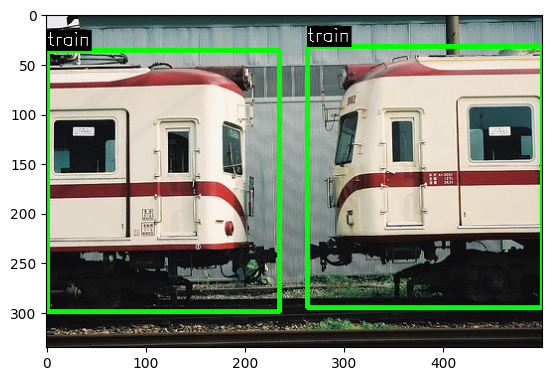

In [7]:
bounding_box_visualisation(test_img_path, get_bounding_box(test_xml_path))

## 1.3 RPN from scratch

In [8]:
class ODDataset(Dataset):
    def __init__(self, img_list, img_size=IMG_SIZE):
        self.image_list = img_list
        self.img_size = img_size

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = cv2.imread(image_path)
        scale_factor_x, scale_factor_y = self.img_size[1] / image.shape[1], self.img_size[0] / image.shape[0]
        image = cv2.resize(image, self.img_size)
        image = image / 255
        image = torch.FloatTensor(image).permute(2, 0, 1)

        label = self.extract_box(image_path, scale_factor_x, scale_factor_y)

        return image, label

    @staticmethod
    def extract_box(image_path, x_scale=1, y_scale=1):
        ## Slightly different from the function implemented above as bbox format of xyxy makes some calculations easier
        filename, _ = os.path.splitext(os.path.basename(image_path))
        file_path = os.path.join("VOC2012/Annotations", filename + ".xml")
        ret = []
        tree = ET.parse(file_path)
        for tag in tree.findall('object'):
            name = tag.find("name").text
            bndbox = tag.find("bndbox")
            xmin = int(float(bndbox.find("xmin").text) * x_scale)
            xmax = int(float(bndbox.find("xmax").text) * x_scale)
            ymin = int(float(bndbox.find("ymin").text) * y_scale)
            ymax = int(float(bndbox.find("ymax").text) * y_scale)

            ret.append((class_dict[name], xmin, ymin, xmax, ymax))
        return torch.Tensor(ret)

    @staticmethod
    def collate_fn(batch):
        # Defining this function to so that pytorch dataloader can handle variable length inputs
        images = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images = torch.stack(images, dim=0)
        labels = pad_sequence(labels, batch_first=True, padding_value=-1)
        return images, labels

    def __len__(self):
        return len(self.image_list)

In [9]:
def generate_anchor_centers(size=(25, 25)):
    """
    Generate list of anchor centers which is basically all the points on feature map.
    :param size: size of feature map
    :return: list of centers (x,y)
    """
    h, w = size
    x = np.arange(0, w)
    y = np.arange(0, h)
    center_list = np.array(np.meshgrid(x, y, sparse=False, indexing='xy')).T.reshape(-1, 2)
    return torch.from_numpy(center_list)


def generate_anchor_boxes(scales, ratios, centers=None, image_size=(25, 25)):
    """
    Generate anchor boxes as per the arguments
    :param scales: scale of anchor boxeas
    :param ratios: ratio between height and width
    :param centers: list of anchor points
    :param image_size: size of feature map
    :return: list or anchor boxes
    """
    c = 0
    if centers is None:
        centers = generate_anchor_centers(size=image_size)
    anchor_boxes = torch.zeros((centers.shape[0] * len(scales) * len(ratios), 4))
    for x, y in centers:
        for scale in scales:
            for ratio in ratios:
                w = scale * ratio
                h = scale

                x_min = x - w / 2
                y_min = y - h / 2
                x_max = x + w / 2
                y_max = y + h / 2

                anchor_boxes[c, :] = torch.tensor([x_min, y_min, x_max, y_max])
                c += 1
    ## This function clips the anchor boxes such that all the boxes are inside the image            
    anchor_boxes = ops.clip_boxes_to_image(anchor_boxes, size=image_size)
    return anchor_boxes.to(DEVICE)


def project_bboxes(bboxes, batch_size=-1, input_size=(800, 800), output_size=(25, 25)):
    """
    Projects bounding boxes from one space to another
    :param bboxes: list of bounding box
    :param input_size: input space size
    :param output_size: output space size
    :return: projected bounding boxes
    """
    ih, iw = input_size
    oh, ow = output_size

    h_scale, w_scale = oh / ih, ow / iw

    batch_size = 1 if batch_size == -1 else bboxes.size(dim=0)
    projected_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (bboxes == -1)  # indicating padded bboxes

    projected_bboxes[:, :, [0, 2]] *= w_scale
    projected_bboxes[:, :, [1, 3]] *= h_scale

    # This will basically ensure that the padded box always get 0 iou    
    projected_bboxes.masked_fill_(invalid_bbox_mask, -1)  # fill padded bboxes back with -1
    projected_bboxes.resize_as_(bboxes)

    return projected_bboxes


def calculate_iou_matrix(anchor_boxes, gt_bboxes):
    # create a placeholder to compute IoUs amongst the boxes
    batch_size = gt_bboxes.shape[0]
    ious_mat = torch.zeros((batch_size, anchor_boxes.size(dim=0), gt_bboxes.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        i_gt_bboxes = gt_bboxes[i]
        iou_mat = ops.box_iou(anchor_boxes, i_gt_bboxes)
        nan_mask = torch.isnan(iou_mat)
        iou_mat[nan_mask] = 0
        ious_mat[i, :] = iou_mat
    return ious_mat.to(DEVICE)


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    """

    :param pos_anc_coords: anchors with IOU above positive threshold
    :param gt_bbox_mapping: ground truth bbox mapped to feature space
    :return: calculates offset values to train regression head on
    """
    #This converts the box from (xmin, ymin, xmax, ymax) format to (center_x, center_y, widht, height) format for easy offset calculation.
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:,
                                                                                                    3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:,
                                                                                                     3]

    tx_ = (gt_cx - anc_cx) / anc_w
    ty_ = (gt_cy - anc_cy) / anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1).to(DEVICE)


def generate_proposals(bboxes, offsets):
    """
    :param bboxes: bounding boxes
    :param offsets: offsets
    :return: apply the offsets on anchor boxes to return the final position of bounding box
    """
    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    bboxes = ops.box_convert(bboxes, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(bboxes)
    proposals_[:, 0] = bboxes[:, 0] + offsets[:, 0] * bboxes[:, 2]
    proposals_[:, 1] = bboxes[:, 1] + offsets[:, 1] * bboxes[:, 3]
    proposals_[:, 2] = bboxes[:, 2] * torch.exp(offsets[:, 2])
    proposals_[:, 3] = bboxes[:, 3] * torch.exp(offsets[:, 3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals.to(DEVICE)


def process_anchor_box_with_gt_bbox(anchor_boxes, gt_bboxes):
    """
    :param anchor_boxes: template anchor boxes (feat_w x feat_h x scales x ratios)
    :param gt_bboxes: ground truth bounding boxes

    This function prepares the data required to train the model, including positive and negative bounding boxes.
    """
    batch_size = gt_bboxes.shape[0]
    iou_matrix = calculate_iou_matrix(anchor_boxes, gt_bboxes)
    num_bbox = iou_matrix.shape[2]
    num_anchor_box = iou_matrix.shape[1]
    ## max iou per gt box per image
    max_iou_per_gt_bbox = iou_matrix.max(dim=1, keepdim=True)[0]

    #finding positive anchor box:
    positive_anchor_mask = torch.logical_and(iou_matrix == max_iou_per_gt_bbox, max_iou_per_gt_bbox > 0)
    positive_anchor_mask = torch.logical_or(positive_anchor_mask, iou_matrix > POSITIVE_THRESHOLD)

    ## Will flatten the anchor masks and keep track of batch number in a separate variable.
    positive_anchor_mask_flat = positive_anchor_mask.flatten(end_dim=1)
    positive_anchor_ind = torch.where(positive_anchor_mask_flat)[0]

    max_iou_per_anchor, max_iou_per_anc_ind = iou_matrix.max(dim=-1)
    max_iou_per_anchor = max_iou_per_anchor.flatten(start_dim=0, end_dim=1)

    anc_boxes_flat = anchor_boxes.repeat(batch_size, 1, 1).flatten(start_dim=0,
                                                                   end_dim=-2)  # flatten all the anchor boxes
    positive_anchor_coords = anc_boxes_flat[positive_anchor_ind]

    ##same for negative:
    negative_anchor_mask = (max_iou_per_anchor < NEGATIVE_THRESHOLD)
    negative_anchor_ind = torch.where(negative_anchor_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anchor_ind = negative_anchor_ind[
        torch.randint(0, negative_anchor_ind.shape[0], (positive_anchor_ind.shape[0],))]

    gt_bboxes_expand = gt_bboxes.view(batch_size, 1, num_bbox, 4).expand(batch_size, num_anchor_box, num_bbox, 4)
    gt_bbox_match = torch.gather(gt_bboxes_expand, -2,
                                 max_iou_per_anc_ind.reshape(batch_size, num_anchor_box, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    gt_bbox_match = gt_bbox_match.flatten(start_dim=0, end_dim=2)
    gt_bbox_match_pos = gt_bbox_match[positive_anchor_ind]
    gt_offsets = calc_gt_offsets(positive_anchor_coords, gt_bbox_match_pos)

    return positive_anchor_ind, negative_anchor_ind, gt_offsets

In [10]:
def nms(proposals, confidence_scores, nms_thresh=0.01):
    # Non maximum supression function
    sorted_indices = torch.argsort(confidence_scores, descending=True)
    selected_indices = []
    while len(sorted_indices) > 0:
        # Pick the box with the highest confidence score
        best_index = sorted_indices[0].item()
        selected_indices.append(best_index)

        # Calculate IoU with the best box
        ious = ops.box_iou(proposals[best_index].unsqueeze(dim=0), proposals[sorted_indices])

        # Find the indices of boxes with IoU less than the threshold
        below_threshold = (ious < nms_thresh)[0]

        # Remove boxes with high IoU from consideration
        sorted_indices = sorted_indices[below_threshold][1:]

    return selected_indices

In [11]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size=(800, 800)):
        super().__init__()

        self.in_h, self.in_w = img_size
        self.feat_channels, self.out_h, self.out_w = self.__get_feature_map_size()[1:]

        # downsampling scale factor 
        self.width_scale_factor = self.in_w // self.out_w
        self.height_scale_factor = self.in_h // self.out_h

        # scales and ratios for anchor boxes
        self.num_anchor_boxes = len(ANCHOR_SCALES) * len(ANCHOR_RATIOS)

        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

        # weights for loss
        self.w_conf = 1
        self.w_reg = 5

        backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[0])

        self.layer = nn.Sequential(
            nn.Conv2d(self.feat_channels, self.feat_channels, kernel_size=3, padding=1),
            nn.Dropout(0.3),
            nn.ReLU(True)
        )
        self.box_score_predictor = nn.Sequential(nn.Conv2d(self.feat_channels, self.num_anchor_boxes, kernel_size=1),
                                                 nn.Sigmoid())
        self.regressor = nn.Conv2d(self.feat_channels, self.num_anchor_boxes * 4, kernel_size=1)

    def __get_feature_map_size(self):
        tensor = torch.rand(1, 3, self.in_h, self.in_w)
        backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        feature_extractor = nn.Sequential(*list(backbone.children())[0])
        return feature_extractor(tensor).shape

    def __forward_pass(self, images):
        feature_map = self.feature_extractor(images)
        process_feat = self.layer(feature_map)
        confidence_score = self.box_score_predictor(process_feat)
        pred_offset = self.regressor(process_feat)
        return feature_map, confidence_score, pred_offset

    def __gen_and_proocess_anchor_bboxes(self, gt_bboxes):
        # generate anchor boxes
        anchor_boxes = generate_anchor_boxes(ANCHOR_SCALES, ANCHOR_RATIOS, image_size=(self.out_h, self.out_w))
        batch_size = gt_bboxes.size(dim=0)
        #Project ground truth box into feature space
        projected_gt_bboxes = project_bboxes(gt_bboxes, input_size=(self.in_h, self.in_w),
                                             output_size=(self.out_h, self.out_w), batch_size=batch_size)
        return process_anchor_box_with_gt_bbox(anchor_boxes, projected_gt_bboxes)

    def forward(self, images, labels=None):
        if not self.training or labels is None:
            return self.__inference(images)
        feature_map, confidence_score, pred_offset = self.__forward_pass(images)
        gt_bboxes = labels[:, :, 1:]

        positive_anchor_ind, negative_anchor_ind, gt_offsets = self.__gen_and_proocess_anchor_bboxes(gt_bboxes)

        positive_conf_score = confidence_score.flatten()[positive_anchor_ind]
        negative_conf_score = confidence_score.flatten()[negative_anchor_ind]

        offsets_pos = pred_offset.contiguous().view(-1, 4)[positive_anchor_ind]

        confidence_loss = self.conf_loss(positive_conf_score, negative_conf_score)
        offset_loss = self.offset_loss(gt_offsets, offsets_pos)
        return self.w_conf * confidence_loss + self.w_reg * offset_loss

    def __inference(self, image):
        image = image.unsqueeze(dim=0)

        feature_map, confidence_score, pred_offset = self.__forward_pass(image)

        anchor_boxes = generate_anchor_boxes(ANCHOR_SCALES, ANCHOR_RATIOS)
        confidence_score = confidence_score[0].flatten()
        pred_offset = pred_offset[0].reshape(-1, 4)
        proposals = generate_proposals(anchor_boxes, pred_offset)

        pos_confidence_mask = torch.where(confidence_score >= POSITIVE_THRESHOLD)[0]
        pos_confidence = confidence_score[pos_confidence_mask]
        pos_proposals = proposals[pos_confidence_mask]
        return pos_proposals, pos_confidence

    def conf_loss(self, positive_conf_score, negative_conf_score):
        target_pos = torch.ones_like(positive_conf_score)
        target_neg = torch.zeros_like(negative_conf_score)

        target = torch.cat((target_pos, target_neg))
        inputs = torch.cat((positive_conf_score, negative_conf_score))

        loss = F.binary_cross_entropy(inputs, target, reduction="mean")
        return loss

    def offset_loss(self, gt_offsets, offsets_pos):
        assert gt_offsets.size() == offsets_pos.size()
        loss = F.smooth_l1_loss(offsets_pos, gt_offsets, reduction='mean')
        return loss

In [12]:
IMAGE_PATH = "VOC2012/JPEGImages/"
TRAIN_RATIO = 0.7
IMG_SIZE = (800, 800)
ANCHOR_SCALES = [2, 4, 6]
ANCHOR_RATIOS = [0.5, 1, 1.5]
POSITIVE_THRESHOLD = 0.7
NEGATIVE_THRESHOLD = 0.2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
EPOCHS = 1

In [13]:
image_list = glob.glob(f"{IMAGE_PATH}/*.jpg")
np.random.shuffle(image_list)
train_img_list, val_img_list = np.split(image_list, [int(TRAIN_RATIO * len(image_list))])

### Due to limited time I could not train the model on the whole dataset so to demonstrate I am training on a small sample. (Will train on whole dataset later for few epochs for validity)

In [14]:
with open('small_img_list.txt', 'r') as f:
    small_img_list = f.read().split('\n')
train_dataset = ODDataset(small_img_list)
train_dataloader = DataLoader(train_dataset, collate_fn=ODDataset.collate_fn, batch_size=BATCH_SIZE, shuffle=True)

In [45]:
rpn_model = RegionProposalNetwork().to(DEVICE)
optimizer = torch.optim.Adam(rpn_model.parameters(), lr=5e-6)
rpn_model=rpn_model.train()

In [17]:
loss_list = []
small_epochs = 500
for epoch in tqdm(range(small_epochs)):
    for image, label in train_dataloader:
        image, label = image.to(DEVICE), label.to(DEVICE)
        loss = rpn_model(image, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
torch.save(rpn_model.state_dict(), f"small_weights_{epoch}.pth")

100%|█████████████████████████████████████████| 500/500 [59:50<00:00,  7.18s/it]


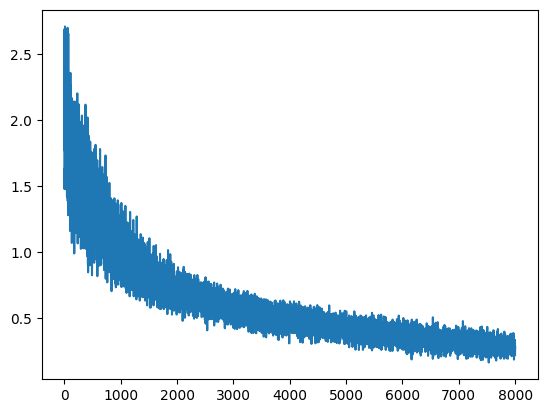

In [21]:
plt.plot(loss_list)

In [86]:
def bounding_box_visualisation_for_tensor(image, box_array, color):
    project_predv = project_bboxes(box_array.detach().cpu(), input_size=(25,25), output_size=(800,800), batch_size=-1)
    img = (image.detach().cpu().permute(1,2,0).numpy()*255).astype(np.uint8).copy()
    img = np.ascontiguousarray(img, dtype=np.uint8)
    for box in project_predv:
        img = cv2.rectangle(img, (int(box[0].item()), int(box[1].item())), (int(box[2].item()), int(box[3].item())), color, 3)
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

506


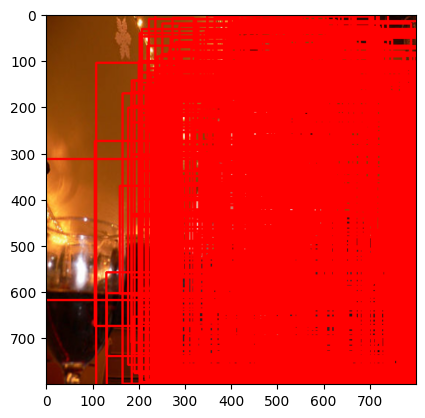

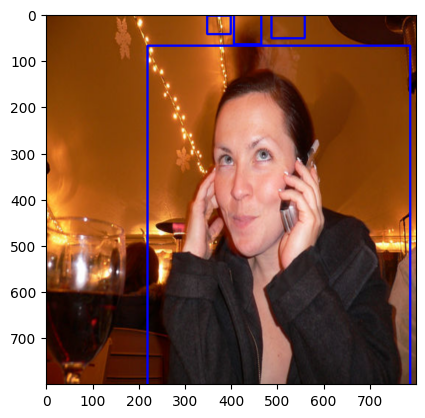

In [88]:
rpn_model.load_state_dict(torch.load('small_weights_499.pth'))
rpn_model.eval()
i = 3
prop, conf = rpn_model(image[i])
print(len(prop))
nmsId= nms(prop, conf, nms_thresh=0.0005)
bounding_box_visualisation_for_tensor(image[i], prop, color=(0,0,255)) ##Plotting without NMS
bounding_box_visualisation_for_tensor(image[i], prop[nmsId], color=(255,0,0)) #Plotting after NMS

# Training on full dataset

In [15]:
train_dataset = ODDataset(train_img_list)
val_dataset = ODDataset(val_img_list)

train_dataloader = DataLoader(train_dataset, collate_fn=ODDataset.collate_fn, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=ODDataset.collate_fn, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
loss_list = []
for e in range(12):
    for image, label in tqdm(train_dataloader):
        image, label = image.to(DEVICE), label.to(DEVICE)
        loss, prop = rpn_model(image, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    torch.save(rpn_model.state_dict(), f"weights_{e}.pth")

### I am attaching loss graph from previous experiment as I do not have time to rerun this whole train loop
![Loss Graph](full_data_set_training.png)